<h2> Estimate the Author-Topic Model </h2>

In [1]:
import gzip
import json
import pickle
import pandas as pd
import numpy as np

from gensim import corpora
from gensim.models import AuthorTopicModel

from tqdm import tqdm

from gensim.matutils import dirichlet_expectation
from gensim.test.utils import datapath
import logging

import re

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "white"

In [2]:
inputs_path = "C:/Users/Hannes/Documents/Joe/TeamsAndText/Inputs"
intermediate_outputs_path = "C:/Users/Hannes/Documents/Joe/TeamsAndText/IntermediateOutputs"
results_path = "C:/Users/Hannes/Documents/Joe/TeamsAndText/Results"

In [3]:
logging.basicConfig(filename=f'{results_path}/atmodel_log.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)
logging.info('Creating new log file.')

In [4]:
num_iters = 100

In [5]:
with gzip.open(f"{intermediate_outputs_path}/corpus.json.gz", 'r') as fin:  
    json_bytes = fin.read()                     

json_str = json_bytes.decode('utf-8')            
corpus = json.loads(json_str)  

In [6]:
dictionary = pickle.load(open(f"{intermediate_outputs_path}/id2word.p", "rb")) 
doc2inv = pickle.load(open(f"{intermediate_outputs_path}/doc2inv.p", "rb"))
inv2doc = pickle.load(open(f"{intermediate_outputs_path}/inv2doc.p", "rb"))
print(len(dictionary))

332780


In [7]:
%%time
num_topics = 20
model = AuthorTopicModel(corpus, id2word=dictionary, author2doc=inv2doc, doc2author=doc2inv, num_topics=num_topics,
                         iterations=num_iters, random_state=1234, alpha="auto", eta="auto", gamma_threshold=0.0001,
                        eval_every=5) 

Wall time: 38min 8s


In [8]:
temp_file = datapath(f"{intermediate_outputs_path}/model")
model.save(temp_file)

In [9]:
gamma = model.state.gamma
np.save(f"{intermediate_outputs_path}/model.state.gamma.npy", gamma)

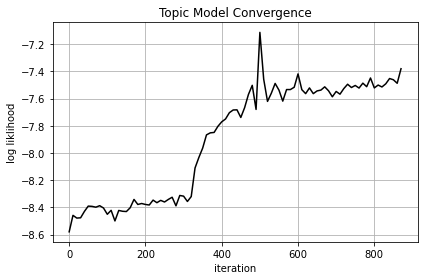

In [10]:
p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open(f'{results_path}/atmodel_log.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
likelihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter, likelihood, c="black")
plt.ylabel("log liklihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.tight_layout()
plt.savefig(f"{results_path}/likelihood_convergence.png", dpi=300)
#pickle.dump(liklihood, open(f"{results_path}/likelihood".p", "wb"))

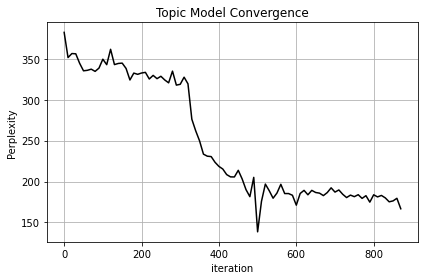

In [11]:
plt.plot(iter, perplexity, c="black")
plt.ylabel("Perplexity")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.tight_layout()
#plt.savefig(f"{results_path}/likelihood_convergence.png", dpi=300)
#pickle.dump(liklihood, open(f"{results_path}/likelihood".p", "wb"))

In [12]:
inv2id = {inv:id_i for id_i, inv in model.id2author.items()}
author_dists = {author : model.get_author_topics(author) for author in model.id2author.values()}
print(len(author_dists))

549961


In [13]:
author_dists_matched = pd.DataFrame(columns=np.arange(num_topics))
author_dists_matched["inventor_id"] = author_dists.keys()
for num_id, inv_dist in enumerate(tqdm(author_dists.values())):
    for topic, weight in inv_dist:
        author_dists_matched.at[num_id, topic] = weight
author_dists_matched.set_index("inventor_id", inplace=True)
author_dists_matched = author_dists_matched.fillna(0)
author_dists_matched = author_dists_matched.div(author_dists_matched.sum(axis=1), axis=0)
author_dists_matched.head()

100%|███████████████████████████████████████████████████████████████████████| 549961/549961 [00:40<00:00, 13689.06it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
inventor_id,,,,,,,,,,,,,,,,,,,,
000f0k6brgval6kr9agzjlgcg,0.064537,0.028634,0.018825,0.019273,0.049114,0.021086,0.017793,0.016962,0.015963,0.021822,0.031646,0.227510,0.013055,0.023864,0.016004,0.032771,0.018583,0.300064,0.016572,0.045921
000s9qy0x4l3x4n99bv2a1qn4,0.036235,0.029636,0.038960,0.035015,0.036463,0.046972,0.030500,0.039450,0.080068,0.103947,0.029732,0.040881,0.031187,0.086560,0.033716,0.047335,0.106933,0.043066,0.032691,0.070653
003gl0pmpob62w5yf9j8xw1c8,0.052592,0.017268,0.014634,0.014272,0.018287,0.020108,0.178831,0.000000,0.013428,0.169293,0.025588,0.170891,0.018351,0.032492,0.012810,0.014909,0.012661,0.175302,0.019602,0.018679
003ibk308p0r5efhppfnkpghy,0.035597,0.042729,0.067434,0.135890,0.049154,0.032987,0.035689,0.027072,0.031900,0.036260,0.029895,0.033401,0.028006,0.039150,0.027994,0.057273,0.040069,0.037598,0.173078,0.038823
004sxraydhup13ce43vyj61p1,0.044167,0.013710,0.016535,0.712317,0.011090,0.000000,0.013478,0.000000,0.000000,0.013224,0.012292,0.047486,0.000000,0.011032,0.000000,0.011988,0.000000,0.033351,0.011965,0.047366


In [14]:
center = np.array([1/num_topics]*num_topics)
inventor_distance_center = dict.fromkeys(author_dists_matched.index)
for inv in author_dists_matched.index:
    d_center = np.linalg.norm(author_dists_matched.loc[inv] - center)
    inventor_distance_center[inv] = d_center

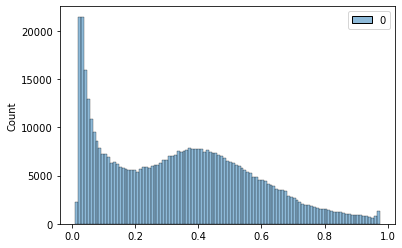

In [15]:
fig, ax = plt.subplots()
sns.histplot(inventor_distance_center.values(), ax=ax)
plt.savefig(f"{results_path}/inventor_distance_hist.png", dpi=300)

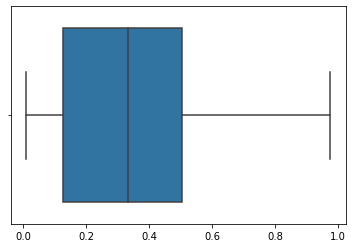

In [16]:
fig, ax = plt.subplots()
sns.boxplot(x=list(inventor_distance_center.values()))
plt.savefig(f"{results_path}/inventor_distance_boxplot.png", dpi=300)

In [17]:
topic_distributions = np.transpose(model.get_topics())
topic_distributions = pd.DataFrame(topic_distributions, columns=np.arange(num_topics))
np.shape(topic_distributions)

(332780, 20)

In [18]:
pickle.dump(inv2id, open(f"{intermediate_outputs_path}/inv2id.p", "wb"))
topic_distributions.to_csv(f"{results_path}/topic_distributions.csv")
author_dists_matched.to_csv(f"{results_path}/inventor_distributions.csv")

In [19]:
len(corpus)

876535